# Insight Summary

This notebook presents an in-depth analysis of NYC campaign contributions from 2007 onward, using a cleaned subset of the original dataset. The analysis covers  
key trends in donation behavior, geography, timing, and donor characteristics.

### Key Findings

- Donation Behavior  
The vast majority of contributions are small-dollar amounts under 2000, with distinct peaks at round numbers like \$50, \$100, and \$250. This highlights  
the dominance of individual contributors and recurring donation norms.

- Temporal Trends  
Spikes in donation volume and frequency align with mayoral election years like 2009, 2013, 2017, showing a clear cyclical pattern in political engagement.  
The 2025 cycle had a particularly high surge in donation count, indicating increased grassroots involvement.

- Geographic Insights  
As expected, New York state contributes the most by far in both volume and number of donations. However, states like California and New Jersey show notable  
participation, suggesting some interstate fundraising reach.

- Donor Profile  
Many donors omit employer or occupation data, though sufficient clean records remain for aggregate analysis. There are visible clusters around common job  
titles like teacher, lawyer, and retiree which can inform targeting strategies. There is also significant indication that students, self employed, and  
retirees represent a significant amount of campaign donations.

- Correlation
The only significant correlation present in the numerical data is a ~.6 relationship between `PREVAMNT` and `AMNT`. This is expected as a  
person who donates once is likely to donate again at a similar amount (if they donate again at all). The lack of correlation between the time  
fields and the donation amount fields suggests that donor amount is independent of time of year and relatively independent across the last ~20 years.  
This could be a result of a variety of factors, but stagnant wages, decreased buying power, and low voter enthusiasm could be effecting donation growth over time.

- Descriptive Stats
There was an Average donation amount of 500, but this is skewed up by large donations. The 25%, 50%, and 75% were 25, 100, and 250 respectively.  
This aligns with the idea that the majority of donors are picking specific rounded cut off amounts for their donations. The 3 quartiles for previous  
donations are all \$0 which aligns with the idea that most donors are first time participators. Month also shows a even distribution of donations  
across all months which aligns with the longterm monthly invariance of donations.   


- Data Integrity and Scope  
From the original ~1.4 million rows and 54 columns, the cleaned dataset includes ~600,000 valid entries post 2007, keeping 16 key columns for analysis/validation.  
Columns with excessive null values or redundant information were dropped to ensure quality insights. More info can be found in DataClean.ipynb


# Overview

This notebook conducts exploratory data analysis on a clean subset of the NYC Campaign Contributions dataset.  
The goal is to uncover meaningful patterns in donor behavior, such as donation size distributions, time-based trends, and geographic differences.
This work allows insight for campaign strategy, donor segmentation, and fundraising optimization.

The data was previously cleaned in a separate preprocessing notebook (DataClean.ipynb) and saved as cleaned_campaign_data.csv.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
campaign_df = pd.read_csv("../data/Cleaned_Donor_Data.csv", parse_dates=["DATE"])

campaign_df.head()


,DATE,AMNT,MATCHAMNT,PREVAMNT,NAME,CITY,STATE,ZIP,OCCUPATION,EMPNAME,RECIPNAME,ELECTION,OFFICECD,CANCLASS,PAY_METHOD,C_CODE,YEAR,MONTH,PAY_METHOD_LABEL
0,2008-12-21,50.0,50.0,0.0,"SINGH, KULDIP",NEW HYDE PARK,NY,11040.0,NaN,NaN,"SINGH, SWARANJIT",2009,City Council,NaN,1,IND,2008,12,Cash
1,2009-05-20,10.0,10.0,0.0,"FIGUEROA, BETHSAIDA",BRONX,NY,10475.0,NaN,NaN,"RICE, JEROME L",2009,City Council,NaN,1,IND,2009,5,Cash
2,2009-05-20,10.0,10.0,0.0,"CAMACHO, ANNA",BRONX,NY,10475.0,UNEMPLOYED,NaN,"RICE, JEROME L",2009,City Council,NaN,1,IND,2009,5,Cash
3,2009-07-21,5.0,5.0,0.0,"MCQUEEN, JULIAN",BROOKLYN,NY,11238.0,NaN,NaN,"TALEN, BILLY",2009,Mayor,NaN,1,IND,2009,7,Cash
4,2009-05-12,10.0,10.0,0.0,"ISLAM, MOINUL",OZONE PARK,NY,11416.0,NaN,NaN,"DIAZ, DARMA V",2009,City Council,NaN,1,IND,2009,5,Cash



### Observations:
- `AMNT` (Donation Amount):
  - Most donations are relatively small (median: 75, 75th percentile: \$200).
  - However, the mean is inflated by huge outliers (max: \$8M).
  - Negative values exist which possibly means refunds or chargebacks (e.g., Min: -\$175,000).

- `MATCHAMNT` (Match Amount):
  - Many entries are zero (25th percentile).
  - Significant match potential for certain donors (max: \$10,000).

- `PREVAMNT` (Prior Donations from Donor):
  - Median and 75th percentile are \$0 which suggests most donors are one time or unlinked donors.
  - Extremely high max (\$107M) and huge standard deviation suggest data entry problems or potentially a large institutional donor.

### Next Steps:
- Cap or log-transform `AMNT`/`PREVAMNT` for modeling or visualization to reduce skew.
- Bucket donations to compare different ranges of donation amounts 


In [48]:
pd.set_option('display.float_format', '{:.3f}'.format)
# descriptive stats on the three AMNT columns
display(campaign_df[['AMNT', 'MATCHAMNT', 'PREVAMNT']].describe())
pd.reset_option('display.float_format')

,AMNT,MATCHAMNT,PREVAMNT
count,604462.000,604462.000,604462.000
mean,522.455,49.539,7316.357
std,22412.178,65.480,723086.475
min,0.010,0.000,0.000
25%,25.000,0.000,0.000
50%,100.000,20.000,0.000
75%,250.000,100.000,0.000
max,8000000.000,250.000,107860000.000


### Log Distribution of Donation Amounts

The raw distribution of `AMNT` is highly skewed, with a long tail of very large donations.  
Most contributions cluster below \$200, but a few are up to 8,000,000. This makes direct   
interpretation impossible without transformation.

To better visualize the distribution, I apply a log transform to the donation amounts.  
This clarifies the central mass of contributions, making patterns in smaller donations easier to analyze.

Extreme outliers may need to be capped or excluded entirely in future analysis to avoid distortion.


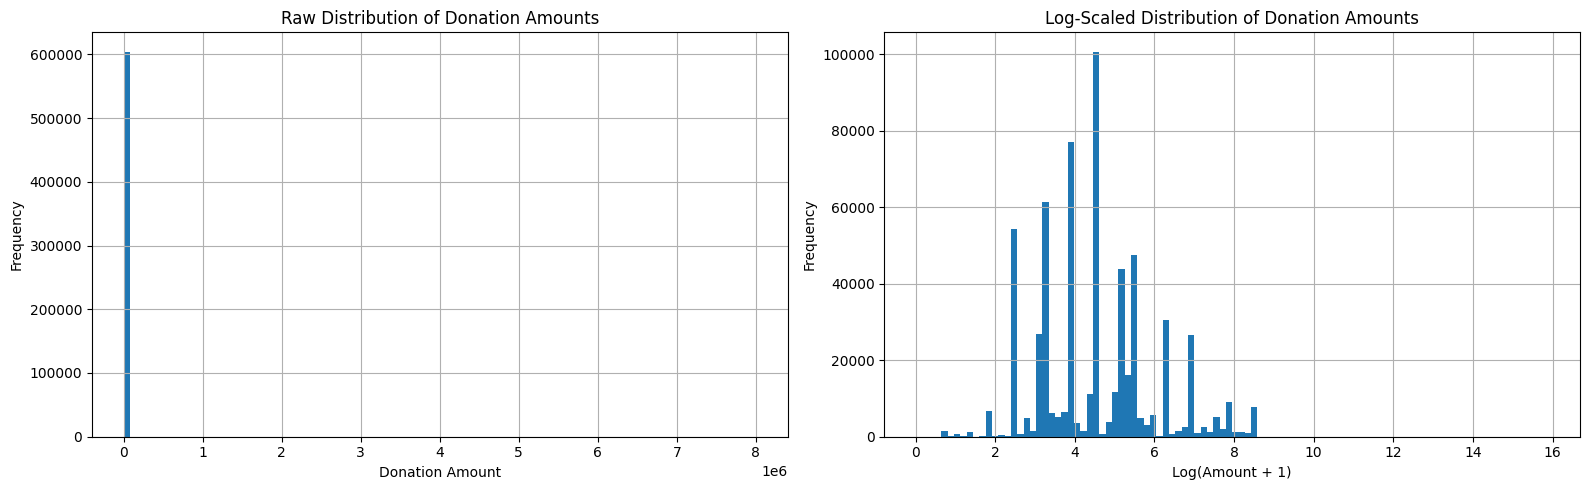

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Compute log scaled donation amount
campaign_df['LOG_AMNT'] = np.log1p(campaign_df['AMNT'])

# Create 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Raw Distribution
campaign_df['AMNT'].hist(bins=100, ax=ax1)
ax1.set_title("Raw Distribution of Donation Amounts")
ax1.set_xlabel("Donation Amount")
ax1.set_ylabel("Frequency")

# Log-Scaled Distribution
campaign_df['LOG_AMNT'].hist(bins=100, ax=ax2)
ax2.set_title("Log-Scaled Distribution of Donation Amounts")
ax2.set_xlabel("Log(Amount + 1)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


## Zoomed in Distribution 

This distribution shows that the vast majority of donations are <\$2000 which suggests most people contribute relatively small amounts.  
There are siginificant peaks at even dollar amounts (50, 100, 250, 500, 1000) which suggests that people often favor giving even and rounded dollar quantities.  
This visualization allows me to distinguish good bins for donation segmentation to be around (0-50, 50-100, 100-250, 250-500, 500-1000, 1000+)

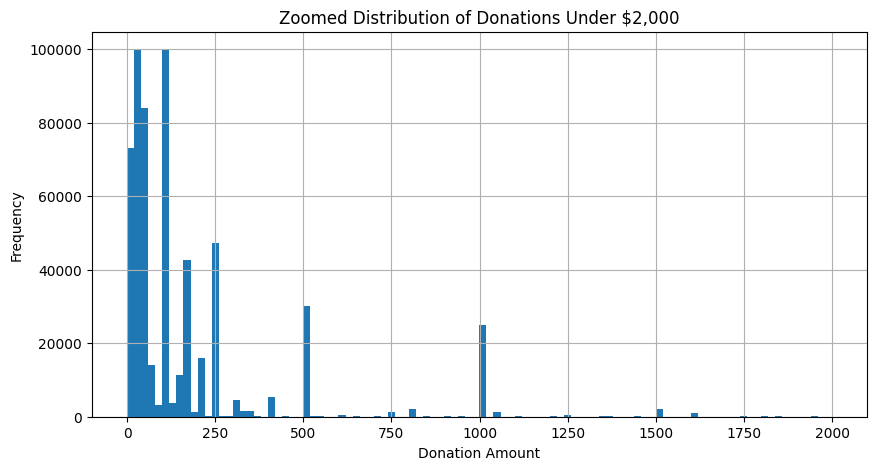

In [51]:
# Limited range (0 <= AMNT < $2000) Distribution

campaign_df[campaign_df['AMNT'] < 2000]['AMNT'].hist(bins=100, figsize=(10,5))
plt.title("Zoomed Distribution of Donations Under $2,000")
plt.xlabel("Donation Amount")
plt.ylabel("Frequency")
plt.show()

## Donation Binning Observations

This bar chart visualizes the frequency of donation amounts segmented into bins.
- The \$100–250 range stands out as the most common donation tier.
- Donations taper significantly after \$500, with relatively few contributions above 2,500.
- The tail of large donations is long but sparse, suggesting donor activity could differ across tiers.

These bins could be used in future analysis for:
- Segmenting donors by behavior
- Evaluating match effectiveness across donation sizes
- Designing tier-specific outreach strategies

<Axes: xlabel='donation_bin'>

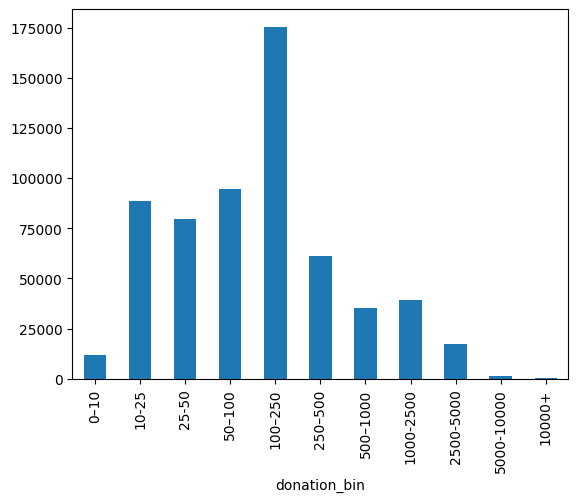

In [52]:
bins = [0, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, float('inf')]
labels = ['0–10', '10-25', '25-50', '50–100', '100–250', '250–500', '500–1000', '1000-2500', '2500-5000', '5000-10000', '10000+']
# group AMNT into donation ranges/bins
campaign_df['donation_bin'] = pd.cut(campaign_df['AMNT'], bins=bins, labels=labels, right=False)
# show distribution of bins
campaign_df['donation_bin'].value_counts().sort_index().plot(kind='bar')

# Time Insights
## Monthly Donation Trends and Patterns (2×2 View)

This 2×2 grid summarizes key dimensions of donation activity over time:

- Topleft: Total donation volume by month  
- Topright: Number of donations per month  
- Bottomleft: Median donation amount per month  
- Bottomright: Normalized trends overlay for all three individual trends

All three charts reveal sharp, cyclical spikes every four years 2009, 2013, 2017, 2021, and 2025 corresponding with NYC's local election cycles.  
These cycles underscore how political activity drives donation surges.

While total dollar volume and donation counts soar in election years, the median donation remains modest, often between \$100 and \$250.  
This contrast suggests most donors give small amounts, while large contributors create outsized impact in total volume.

The normalized overlay helps visualize how volume, count, and median move together or diverge. For example,  
2025 shows a record spike in donation count with a relatively flat median—indicating a grassroots surge of small donations.

These patterns can guide campaign strategy whether targeting broad donor bases or focusing on high-yield contributors.


In [53]:
# Group by year and month
monthly_grouped = campaign_df.dropna(subset=['DATE']).groupby(['YEAR', 'MONTH']).agg({
    'AMNT': ['sum', 'count', 'median']
}).reset_index()

# Rename columns for clarity
monthly_grouped.columns = ['YEAR', 'MONTH', 'TOTAL_DONATION', 'DONATION_COUNT', 'MEDIAN_DONATION']

# Create a datetime column for plotting
monthly_grouped['DATE'] = pd.to_datetime(monthly_grouped[['YEAR', 'MONTH']].assign(DAY=1))

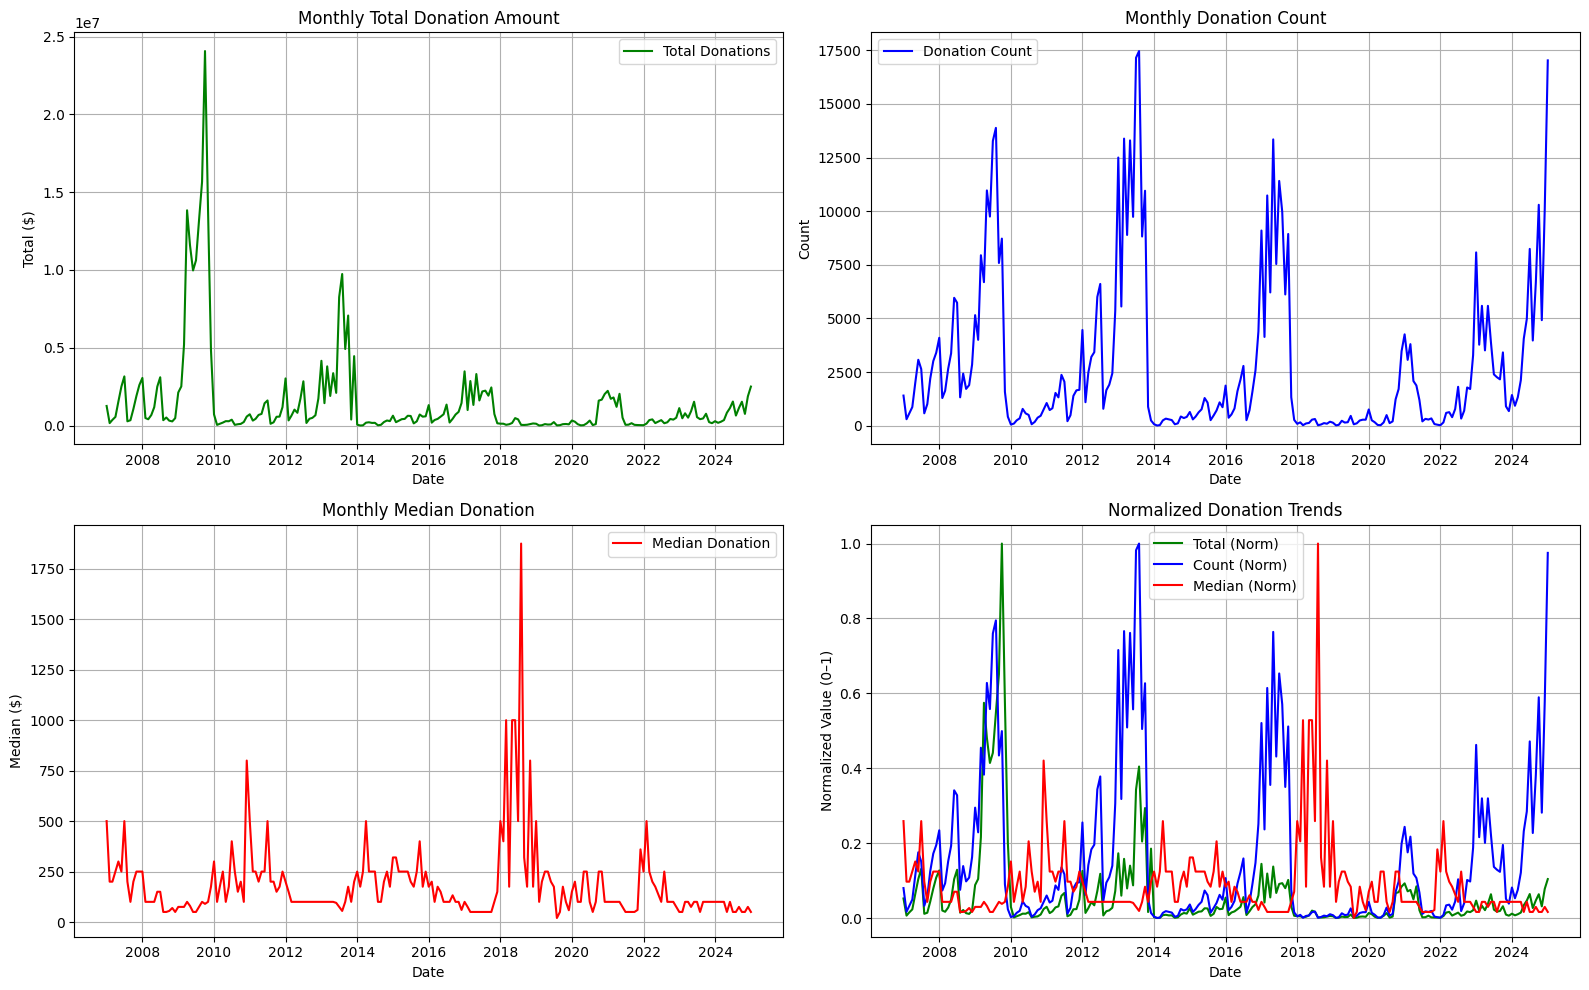

In [63]:
import matplotlib.pyplot as plt

# Normalize for overlay
norm_total = (monthly_grouped['TOTAL_DONATION'] - monthly_grouped['TOTAL_DONATION'].min()) / (monthly_grouped['TOTAL_DONATION'].max() - monthly_grouped['TOTAL_DONATION'].min())
norm_count = (monthly_grouped['DONATION_COUNT'] - monthly_grouped['DONATION_COUNT'].min()) / (monthly_grouped['DONATION_COUNT'].max() - monthly_grouped['DONATION_COUNT'].min())
norm_median = (monthly_grouped['MEDIAN_DONATION'] - monthly_grouped['MEDIAN_DONATION'].min()) / (monthly_grouped['MEDIAN_DONATION'].max() - monthly_grouped['MEDIAN_DONATION'].min())

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Topleft: Total Donation Volume
axes[0, 0].plot(monthly_grouped['DATE'], monthly_grouped['TOTAL_DONATION'], color='green', label='Total Donations')
axes[0, 0].set_title('Monthly Total Donation Amount')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total ($)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Topright: Donation Count
axes[0, 1].plot(monthly_grouped['DATE'], monthly_grouped['DONATION_COUNT'], color='blue', label='Donation Count')
axes[0, 1].set_title('Monthly Donation Count')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Bottomleft: Median Donation
axes[1, 0].plot(monthly_grouped['DATE'], monthly_grouped['MEDIAN_DONATION'], color='red', label='Median Donation')
axes[1, 0].set_title('Monthly Median Donation')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Median ($)')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Bottomright: Normalized Overlay
axes[1, 1].plot(monthly_grouped['DATE'], norm_total, label='Total (Norm)', color='green')
axes[1, 1].plot(monthly_grouped['DATE'], norm_count, label='Count (Norm)', color='blue')
axes[1, 1].plot(monthly_grouped['DATE'], norm_median, label='Median (Norm)', color='red')
axes[1, 1].set_title('Normalized Donation Trends')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Normalized Value (0–1)')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()



# Geographic Insights
## State-by-State Donation Patterns

The first chart shows total donation volume by state, while the second chart displays donation count.  
New York (NY) overwhelmingly leads in both, reflecting the dataset's NYC centric scope and concentration of campaign activity.  

States like New Jersey (NJ), California (CA), and Connecticut (CT) follow distantly, indicating that while some interstate engagement exists,  
most campaign financing remains locally sourced.

A small portion of donations comes from undefined or missing states, but this is a negligible fraction of the dataset.

## Median Donation by State

The third chart highlights median donation amounts by state, providing a alternative view to volume and count.  
Whereas total values can be skewed by a few large donors, the median reflects typical contributor behavior.

Connecticut (CT) and New Jersey (NJ) lead in median donation size, suggesting these states have fewer but more generous donors.  
Conversely, New York (NY) ranks lower, consistent with a broader base of smaller grassroots contributions.

These trends suggest region specific strategies:  
target high-value donors in CT and NJ, while encouraging broader participation in NY through volume-driven efforts.


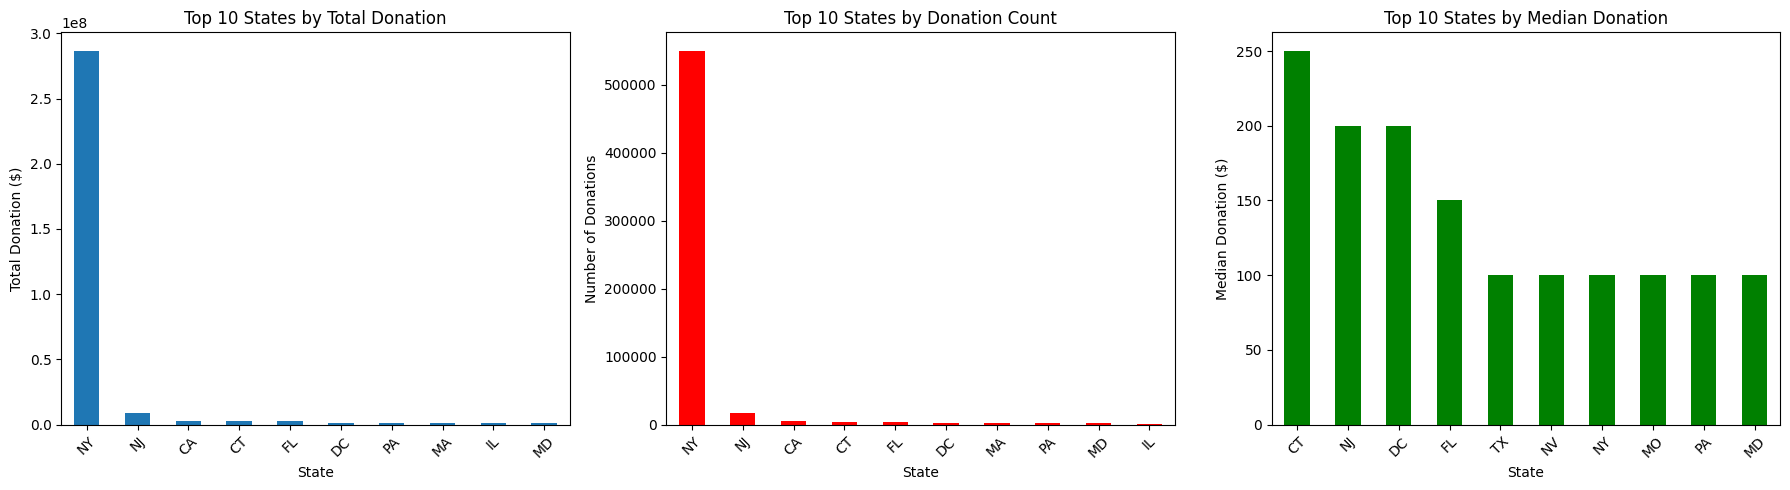

In [66]:
import matplotlib.pyplot as plt

# Aggregate metrics
state_donations = campaign_df.groupby('STATE')['AMNT'].sum().sort_values(ascending=False).head(10)
state_counts = campaign_df['STATE'].value_counts().head(10)
state_medians = campaign_df.groupby('STATE')['AMNT'].median().sort_values(ascending=False).head(10)

# Create 1x3 subplot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Total Donation Amount
state_donations.plot(kind='bar', ax=ax1)
ax1.set_title('Top 10 States by Total Donation')
ax1.set_ylabel('Total Donation ($)')
ax1.set_xlabel('State')
ax1.tick_params(axis='x', rotation=45)

# Donation Count
state_counts.plot(kind='bar', color='red', ax=ax2)
ax2.set_title('Top 10 States by Donation Count')
ax2.set_ylabel('Number of Donations')
ax2.set_xlabel('State')
ax2.tick_params(axis='x', rotation=45)

# Median Donation
state_medians.plot(kind='bar', color='green', ax=ax3)
ax3.set_title('Top 10 States by Median Donation')
ax3.set_ylabel('Median Donation ($)')
ax3.set_xlabel('State')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



# Donor Profile Analysis
## Contributor Type Distributions

The first chart shows the distribution of contributions by contributor type.  
As expected, individuals `IND` make up the overwhelming majority of donations, with over 600,000 contributions.  

To better understand the diversity among non-individual donors, the second chart excludes individuals and better shows other contributor types.  
We see that political committees `PCOMP` are the most active non-individual donors, followed by family members `FAM`, candidates themselves `CAN`,  
and labor unions `EMPO`.

This breakdown highlights the scale of grassroots support, while also revealing the presence of more structured political or organizational giving.  
Such distinctions could be useful for analyzing influence and campaign strategy.

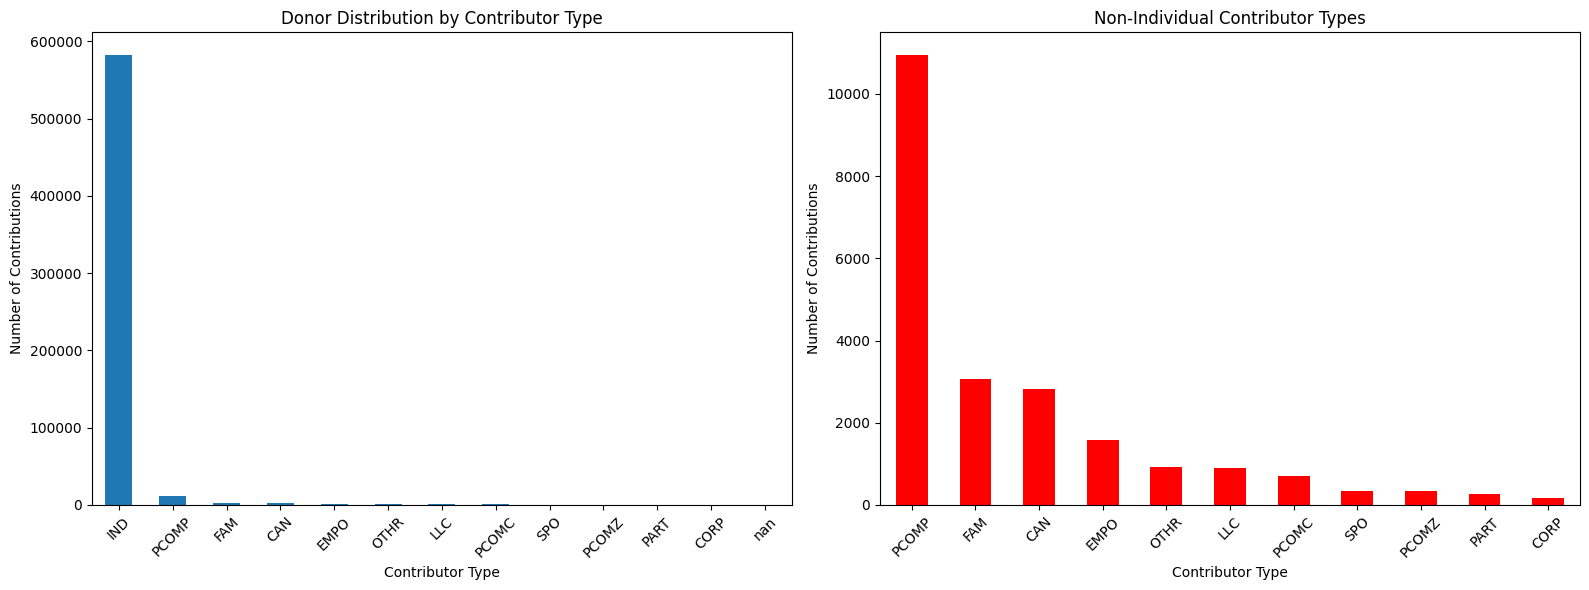

In [68]:
import matplotlib.pyplot as plt

# Prepare data
c_code_counts = campaign_df['C_CODE'].value_counts(dropna=False)
non_ind = campaign_df[campaign_df['C_CODE'] != 'IND']
non_ind_counts = non_ind['C_CODE'].value_counts()

# Create 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot All contributor types
c_code_counts.plot(kind='bar', ax=ax1, title='Donor Distribution by Contributor Type')
ax1.set_xlabel('Contributor Type')
ax1.set_ylabel('Number of Contributions')
ax1.tick_params(axis='x', rotation=45)

# Plot Non-individual contributor types
non_ind_counts.plot(kind='bar', ax=ax2, color='red', title='Non-Individual Contributor Types')
ax2.set_xlabel('Contributor Type')
ax2.set_ylabel('Number of Contributions')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Donor Occupation and Employer Analysis

The first chart shows the most common occupations among contributors.  
Retired individuals are by far the largest donor group, followed by attorneys, unemployed, and consultants.  
This indicates that a significant portion of campaign donations come from individuals with time flexibility or established jobs/background.

The second chart shows the top employers of donors. Some entries such as `SELF-EMPLOYED`, `SELF`, and `NOT EMPLOYED`  
suggest variability in how donors report employment status.  
Other frequent entries include public sector entities like `NYC DOE` and `City of New York`,  
as well as alternative employment types like `STUDENT` and `HOMEMAKER`.

These insights reveal a mix of retirees, public employees, and self-employed individuals driving campaign contributions.  
This profile can help campaigns better target messaging and outreach efforts.

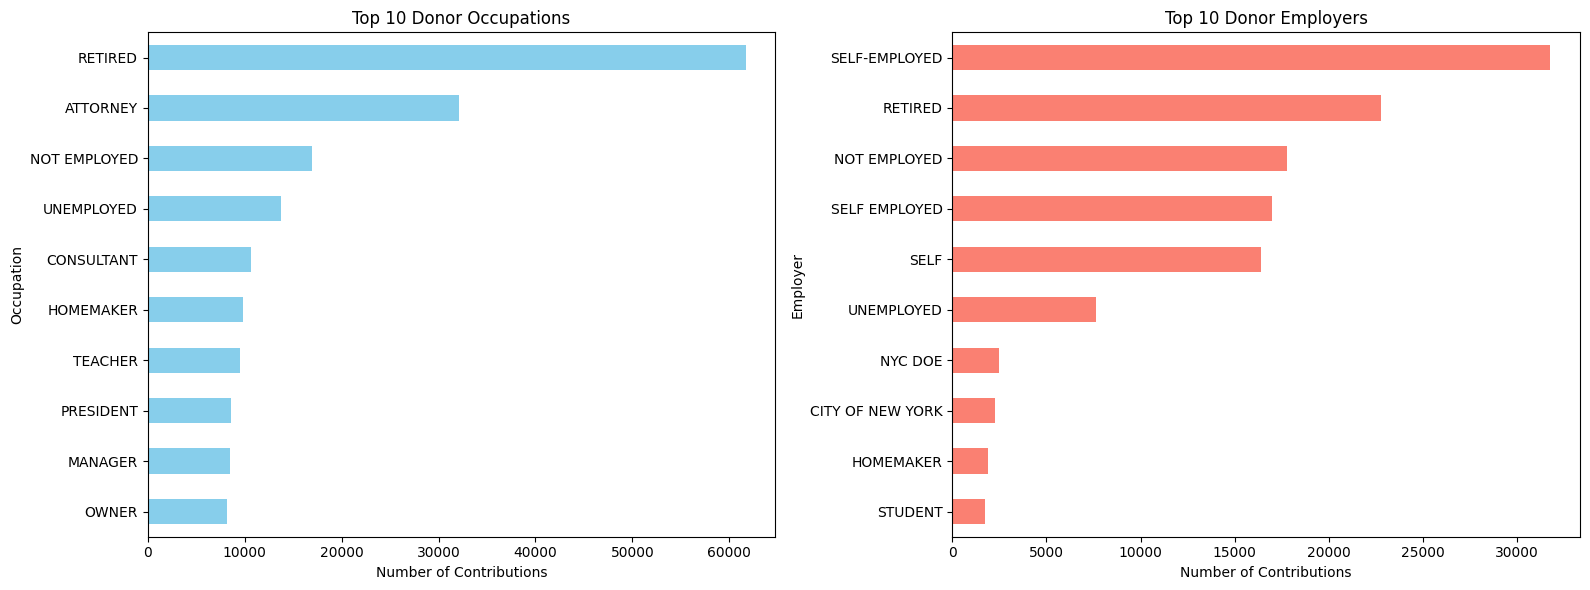

In [69]:
import matplotlib.pyplot as plt

# Prepare data
top_occupations = campaign_df['OCCUPATION'].value_counts().head(10)
top_employers = campaign_df['EMPNAME'].value_counts().head(10)

# Create 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Top Occupations
top_occupations.plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Top 10 Donor Occupations')
ax1.set_xlabel('Number of Contributions')
ax1.set_ylabel('Occupation')
ax1.invert_yaxis()

# Plot Top Employers
top_employers.plot(kind='barh', ax=ax2, color='salmon')
ax2.set_title('Top 10 Donor Employers')
ax2.set_xlabel('Number of Contributions')
ax2.set_ylabel('Employer')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


# Descriptive Stats and Correlation Heatmap

,AMNT,MATCHAMNT,PREVAMNT,YEAR,MONTH
count,6.044620e+05,604462.000000,6.044620e+05,604462.000000,604462.000000
mean,5.224551e+02,49.539380,7.316357e+03,2015.148812,6.217279
std,2.241218e+04,65.479701,7.230865e+05,5.537797,3.276780
min,1.000000e-02,0.000000,0.000000e+00,2007.000000,1.000000
25%,2.500000e+01,0.000000,0.000000e+00,2011.000000,4.000000
50%,1.000000e+02,20.000000,0.000000e+00,2013.000000,6.000000
75%,2.500000e+02,100.000000,0.000000e+00,2020.000000,9.000000
max,8.000000e+06,250.000000,1.078600e+08,2025.000000,12.000000


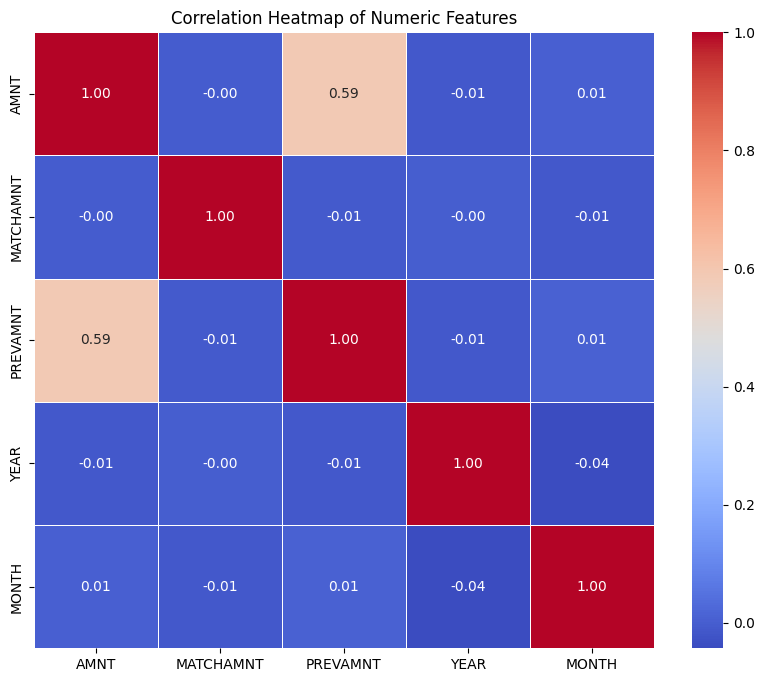

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns and compute correlation matrix
numeric_cols = campaign_df[['AMNT', 'MATCHAMNT','PREVAMNT','YEAR','MONTH']]
corr_matrix = numeric_cols.corr()
display(campaign_df[['AMNT', 'MATCHAMNT','PREVAMNT','YEAR','MONTH']].describe())
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()
